In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    images = np.array(data['filenames'])
    images_targets = np_utils.to_categorical(np.array(data['target']), 2) # [1,0] is no_punch, [0,1] is right_punch
    return images, images_targets

#load training dataset
train_images, train_targets = load_dataset('Images/train') 
test_images, test_targets = load_dataset('Images/test')

print('There are %s total training images.\n' % len(train_images))
print('There are %s total testing images.\n' % len(test_images))

Using TensorFlow backend.


There are 646 total training images.

There are 76 total testing images.



In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_images).astype('float32')/255
test_tensors = paths_to_tensor(test_images).astype('float32')/255

100%|██████████| 76/76 [00:04<00:00, 15.74it/s]


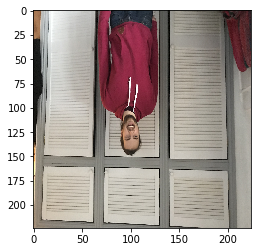

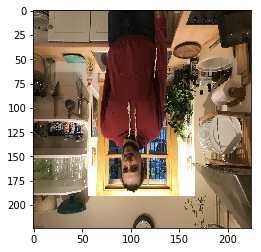

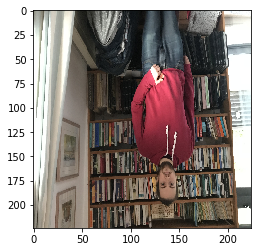

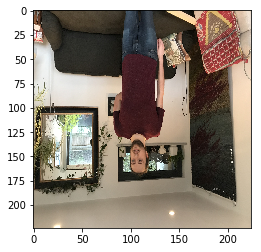

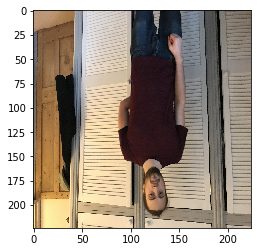

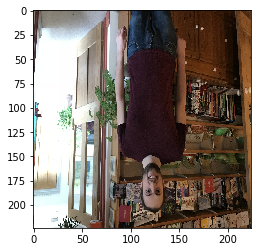

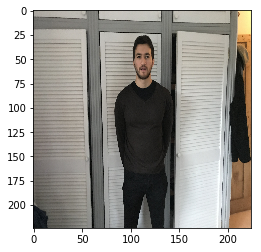

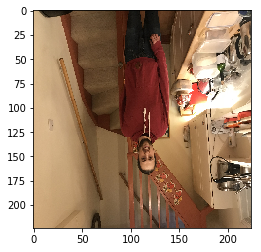

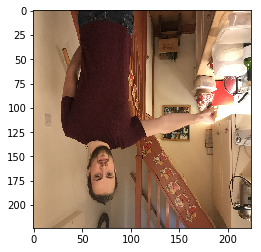

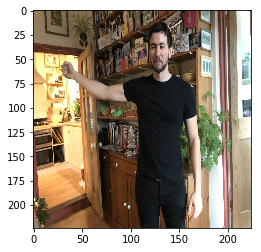

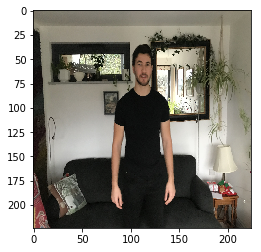

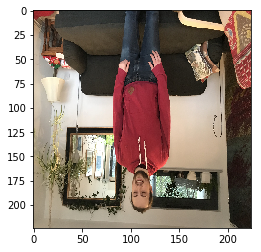

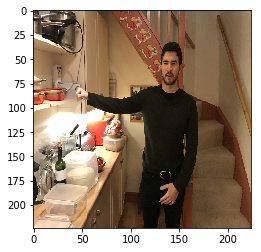

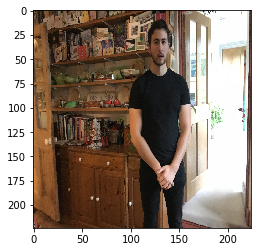

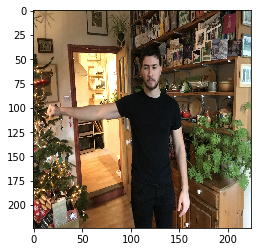

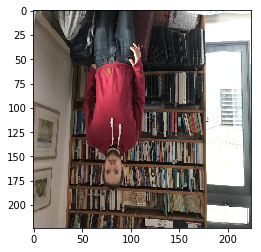

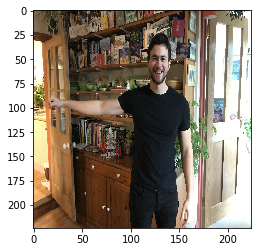

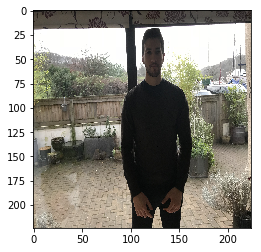

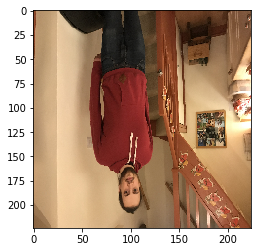

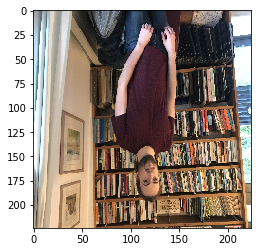

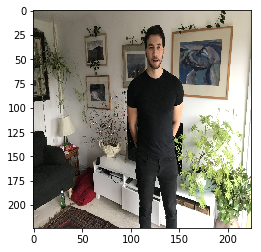

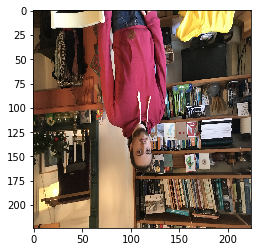

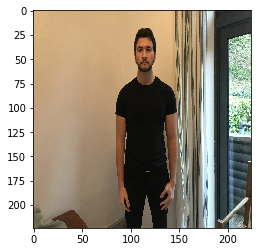

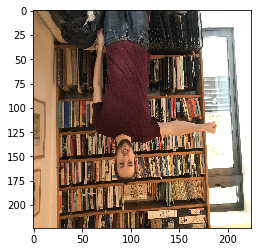

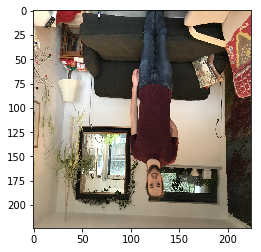

In [88]:
##############################
import matplotlib.pyplot as plt

for i in range (400,425):
    plt.imshow(train_tensors[i, :,:,:])
    plt.show()


In [4]:
from sklearn.model_selection import train_test_split

train_tensors, valid_tensors, train_targets, valid_targets = train_test_split(train_tensors, train_targets, 
                                                                             test_size=0.2, 
                                                                             random_state=42)

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.layers import GaussianNoise
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

epochs = 1000
patience = 20
optimizer= 'rmsprop'


In [6]:
def model_compile_fit(model):
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("Optimizer:", optimizer)
    print("Patience:", patience)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)
    
    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer,
          early_stopping], verbose=2)
    
    model.load_weights('saved_models/weights.best.from_scratch.hdf5')
    
    # get index of predicted action for each image in test set
    action_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(2) #len(2) is len(diff actions)
    print('Test accuracy: %.4f%%' % test_accuracy)
              


In [7]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(input_shape=train_tensors.shape, filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(input_shape=train_tensors.shape, filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation = 'softmax'))

model.summary()

model_compile_fit(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________


Epoch 00041: val_loss improved from 0.53243 to 0.52825, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 42/1000
 - 1s - loss: 0.5741 - acc: 0.7287 - val_loss: 0.5128 - val_acc: 0.7769

Epoch 00042: val_loss improved from 0.52825 to 0.51281, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 43/1000
 - 1s - loss: 0.5753 - acc: 0.6880 - val_loss: 0.5204 - val_acc: 0.8000

Epoch 00043: val_loss did not improve from 0.51281
Epoch 44/1000
 - 1s - loss: 0.5697 - acc: 0.7093 - val_loss: 0.4997 - val_acc: 0.7769

Epoch 00044: val_loss improved from 0.51281 to 0.49969, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 45/1000
 - 1s - loss: 0.5625 - acc: 0.7248 - val_loss: 0.4914 - val_acc: 0.7846

Epoch 00045: val_loss improved from 0.49969 to 0.49144, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 46/1000
 - 1s - loss: 0.5678 - acc: 0.6996 - val_loss: 0.4931 - val_acc: 0.7769

Epoch 00046: val_loss did not improve from 0.4914


Epoch 00148: val_loss did not improve from 0.28667
Epoch 149/1000
 - 1s - loss: 0.3724 - acc: 0.8275 - val_loss: 0.3458 - val_acc: 0.8385

Epoch 00149: val_loss did not improve from 0.28667
Epoch 150/1000
 - 1s - loss: 0.3816 - acc: 0.8314 - val_loss: 0.3411 - val_acc: 0.8692

Epoch 00150: val_loss did not improve from 0.28667
Epoch 151/1000
 - 1s - loss: 0.3541 - acc: 0.8391 - val_loss: 0.3068 - val_acc: 0.8692

Epoch 00151: val_loss did not improve from 0.28667
Epoch 152/1000
 - 1s - loss: 0.3424 - acc: 0.8566 - val_loss: 0.3192 - val_acc: 0.8538

Epoch 00152: val_loss did not improve from 0.28667
Epoch 153/1000
 - 1s - loss: 0.3812 - acc: 0.8198 - val_loss: 0.3045 - val_acc: 0.8769

Epoch 00153: val_loss did not improve from 0.28667
Epoch 154/1000
 - 1s - loss: 0.3642 - acc: 0.8314 - val_loss: 0.2829 - val_acc: 0.8769

Epoch 00154: val_loss improved from 0.28667 to 0.28290, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 155/1000
 - 1s - loss: 0.3536 - acc: 0.8508

In [13]:
model_2 = Sequential()
model_2.add(Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(5,5), padding='same', activation='relu', strides=1))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=train_tensors.shape, filters=32, kernel_size=(4,4), padding='same', activation='relu', strides=1))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=train_tensors.shape, filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=1))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=(224,224,3), filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=1))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=(224,224,3), filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=1))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=(224,224,3), filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=1))
model_2.add(BatchNormalization())
model_2.add(Conv2D(input_shape=(224,224,3), filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=1))
model_2.add(BatchNormalization())
model_2.add(GlobalAveragePooling2D(data_format=None))
model_2.add(Dense(2, activation = 'softmax'))

model_2.summary()
model_compile_fit(model_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 74, 74, 32)        8224      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 37, 37, 64)        18496     
__________

In [20]:
def augmented_data_model_compile_fit(model):
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("Optimizer:", optimizer)
    print("Patience:", patience)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)
    
    #Create and configure augmented image generator

    datagen =ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally (10% of total width)
                                height_shift_range=0.1, # randomly shift images vertically (10% of total height)
                                zoom_range=0.2) # range for random zoom) 
    
    #fit augmented image generator on data
    datagen.fit(train_tensors)
    
    batch_size = 20
    
    # train the model
    model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                          steps_per_epoch=3*(train_tensors.shape[0]//batch_size),
                          epochs=epochs, verbose=2, callbacks=[checkpointer, early_stopping],
                         validation_data=(valid_tensors, valid_targets))
    
    # load the weights that generated the best validation accuracy
    model.load_weights('saved_models/weights.best.from_scratch.hdf5')
       
    # get index of predicted action for each image in test set
    action_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
    print('Test accuracy: %.4f%%' % test_accuracy)

In [15]:
rmsprop_lowLR = optimizers.RMSprop(lr=0.0001)
optimizer= rmsprop_lowLR
patience= 15

aug_model9 = Sequential()
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(5,5), padding='same', activation='relu', strides=1))
aug_model9.add(MaxPooling2D(pool_size=(3,3)))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=train_tensors.shape, filters=32, kernel_size=(4,4), padding='same', activation='relu', strides=1))
aug_model9.add(MaxPooling2D(pool_size=(2,2)))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=train_tensors.shape, filters=64, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=128, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=256, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=512, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(GlobalAveragePooling2D(data_format=None))
aug_model9.add(Dense(2, activation = 'softmax'))

aug_model9.summary()
augmented_data_model_compile_fit(aug_model9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 74, 74, 32)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 64)        18496     
__________

Epoch 00030: val_loss did not improve from 0.00261
Epoch 31/1000
 - 11s - loss: 0.0149 - acc: 0.9958 - val_loss: 0.0238 - val_acc: 0.9846

Epoch 00031: val_loss did not improve from 0.00261
Epoch 32/1000
 - 11s - loss: 0.0139 - acc: 0.9945 - val_loss: 0.0435 - val_acc: 0.9846

Epoch 00032: val_loss did not improve from 0.00261
Epoch 33/1000
 - 11s - loss: 0.0144 - acc: 0.9967 - val_loss: 0.0180 - val_acc: 1.0000

Epoch 00033: val_loss did not improve from 0.00261
Epoch 34/1000
 - 11s - loss: 0.0160 - acc: 0.9938 - val_loss: 0.2050 - val_acc: 0.9538

Epoch 00034: val_loss did not improve from 0.00261
Epoch 35/1000
 - 11s - loss: 0.0078 - acc: 0.9973 - val_loss: 0.2848 - val_acc: 0.9154

Epoch 00035: val_loss did not improve from 0.00261
Epoch 36/1000
 - 11s - loss: 0.0213 - acc: 0.9967 - val_loss: 0.2697 - val_acc: 0.8923

Epoch 00036: val_loss did not improve from 0.00261
Epoch 37/1000
 - 11s - loss: 0.0180 - acc: 0.9960 - val_loss: 0.0220 - val_acc: 0.9923

Epoch 00037: val_loss did n

In [18]:
# load the weights that generated the best validation accuracy
aug_model9.load_weights('saved_models/weights.best.from_scratch.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(aug_model9.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 72.3684%


In [26]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

In [30]:
model = ResNet50(weights='imagenet', include_top=False)

In [76]:
train_bottlenecks = model.predict(train_tensors)
valid_bottlenecks = model.predict(valid_tensors)
test_bottlenecks = model.predict(test_tensors)
print(train_bottlenecks.shape)
print(train_targets.shape)

print(valid_bottlenecks.shape)
print(valid_targets.shape)

print(np.max(valid_bottlenecks))
print(np.max(train_bottlenecks))
print(np.max(test_bottlenecks))

FUCKYOU = np.max(train_bottlenecks)
train_bottlenecks = train_bottlenecks/FUCKYOU
valid_bottlenecks = valid_bottlenecks/FUCKYOU
test_bottlenecks = test_bottlenecks/FUCKYOU



(516, 7, 7, 2048)
(516, 2)
(130, 7, 7, 2048)
(130, 2)
19.166136
18.83619
19.375538


In [74]:
import keras 

dropout = 0.5
transfer_model = Sequential()
transfer_model.add(Dense(1000, input_shape = (7,7,2048), activation='relu'))
transfer_model.add(Dropout(dropout))
transfer_model.add(Flatten())
transfer_model.add(Dense(500, activation='relu'))
transfer_model.add(Dropout(dropout))
transfer_model.add(Dense(200, activation='relu'))
transfer_model.add(Dropout(dropout))
transfer_model.add(Dense(2, activation='sigmoid'))

epochs = 1000
patience = 30

transfer_model.summary()

transfer_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer.hdf5', 
                               verbose=1, save_best_only=True)

transfer_model.fit(train_bottlenecks, train_targets, 
          validation_data=(valid_bottlenecks, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 7, 7, 1000)        2049000   
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 1000)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 49000)             0         
_________________________________________________________________
dense_95 (Dense)             (None, 500)               24500500  
_________________________________________________________________
dropout_23 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
__________

Epoch 00040: val_loss did not improve from 0.22002
Epoch 41/1000
 - 1s - loss: 0.1686 - acc: 0.9438 - val_loss: 0.2573 - val_acc: 0.8923

Epoch 00041: val_loss did not improve from 0.22002
Epoch 42/1000
 - 1s - loss: 0.1432 - acc: 0.9574 - val_loss: 0.2560 - val_acc: 0.9154

Epoch 00042: val_loss did not improve from 0.22002
Epoch 43/1000
 - 1s - loss: 0.1650 - acc: 0.9419 - val_loss: 0.2594 - val_acc: 0.9000

Epoch 00043: val_loss did not improve from 0.22002
Epoch 44/1000
 - 1s - loss: 0.1416 - acc: 0.9516 - val_loss: 0.2212 - val_acc: 0.9077

Epoch 00044: val_loss did not improve from 0.22002
Epoch 45/1000
 - 1s - loss: 0.1295 - acc: 0.9477 - val_loss: 0.2500 - val_acc: 0.9000

Epoch 00045: val_loss did not improve from 0.22002
Epoch 46/1000
 - 1s - loss: 0.1413 - acc: 0.9419 - val_loss: 0.2517 - val_acc: 0.9000

Epoch 00046: val_loss did not improve from 0.22002
Epoch 47/1000
 - 1s - loss: 0.1276 - acc: 0.9535 - val_loss: 0.2953 - val_acc: 0.9000

Epoch 00047: val_loss did not impr

In [78]:
# load the weights that generated the best validation accuracy
transfer_model.load_weights('saved_models/weights.best.transfer.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(transfer_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_bottlenecks]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 65.7895%


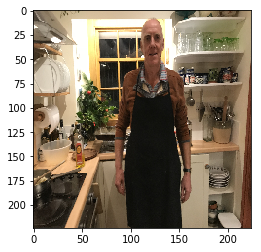

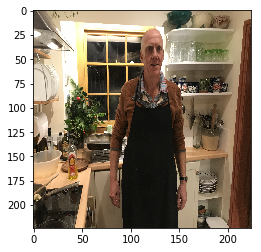

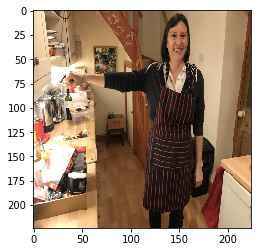

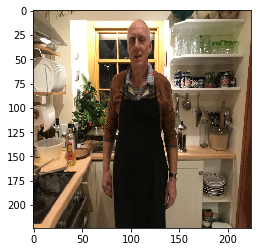

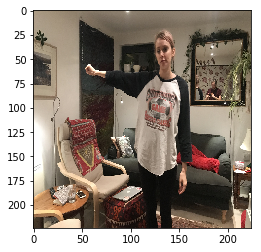

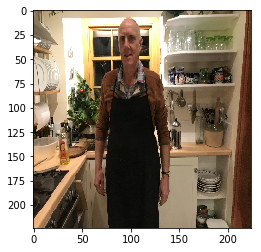

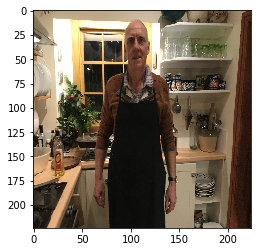

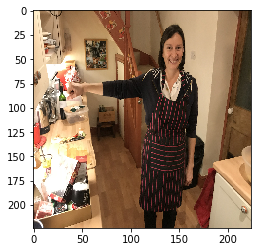

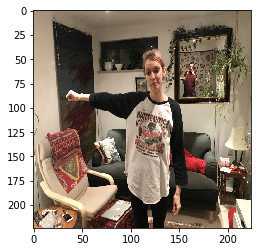

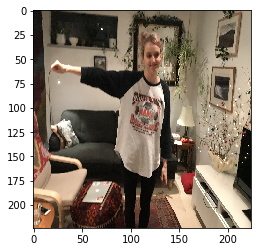

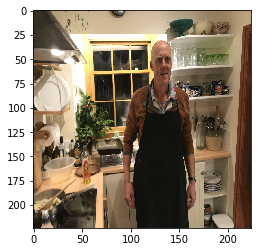

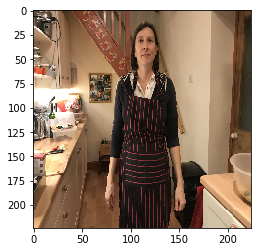

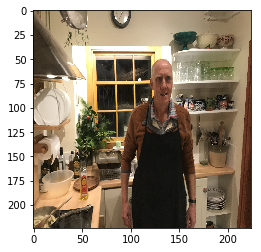

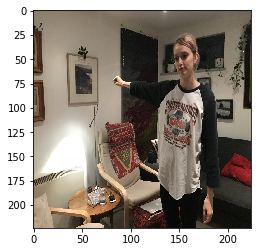

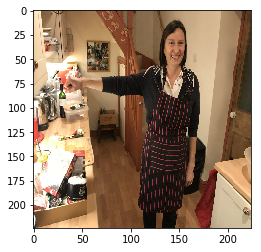

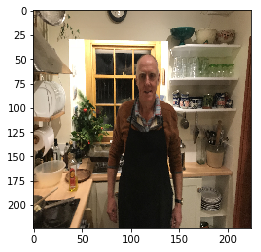

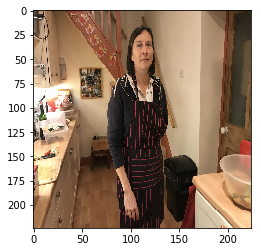

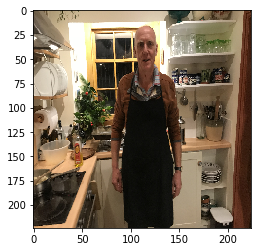

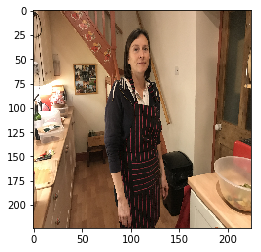

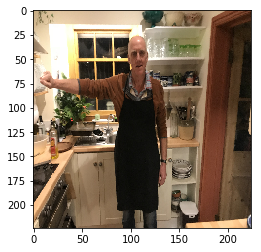

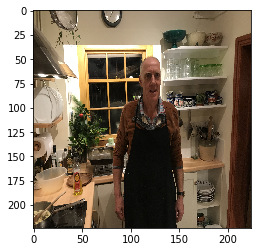

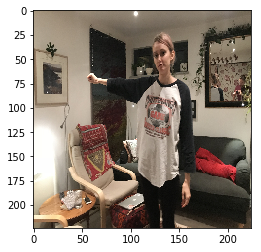

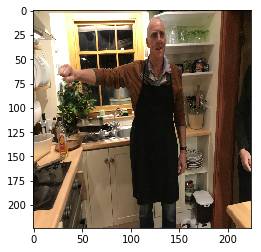

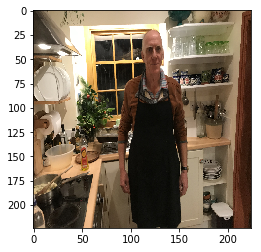

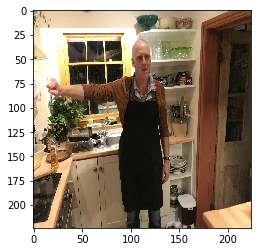

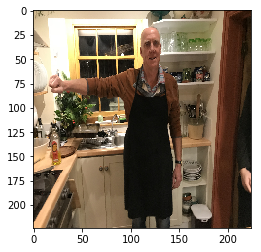

26


In [96]:
count = 0
for i in range(len(action_predictions)):
    
    if np.array(action_predictions[i])!=np.argmax(test_targets[i]):
        count += 1
        plt.imshow(test_tensors[i, :,:,:])
        plt.show()
print(count)
    